In [8]:

import os
import sys
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2

PROJECT_ROOT= r"I:\Group-Activity-Recognition"
sys.path.append(os.path.abspath(PROJECT_ROOT))
from DataLoader import Person , Group

dataset_root = r"I:\Group-Activity-Recognition\dataset"
annot_path =   f"{dataset_root}\\annot_all.pkl"
videos_path =  f"{dataset_root}\\videos"

people_activity_clases = ["Waiting", "Setting", "Digging", "Falling" ,"Spiking"	, "Blocking", "Jumping"	, "Moving", "Standing"]
person_activity_labels  = {class_name.lower():i for i, class_name in enumerate(people_activity_clases)}

group_activity_clases = ["r_set", "r_spike" , "r-pass", "r_winpoint", "l_winpoint", "l-pass", "l-spike", "l_set"]
group_activity_labels  = {class_name:i for i, class_name in enumerate(group_activity_clases)}

activities_labels = {"person": person_activity_labels, "group": group_activity_labels}

train_spilt = [1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54]


In [9]:
transforms = A.Compose([
    A.Resize(224, 224),  
    ToTensorV2()
])

data_loader = Person(videos_path, annot_path, split=train_spilt, seq=False, labels=person_activity_labels, transform=transforms)

In [10]:
len(data_loader)

231327

In [11]:
frame , label = data_loader[0]

label.shape # (,9) class of person activity 

torch.Size([9])

In [12]:
frame , label = data_loader[0]

label.shape # (,9) class of person activity 

torch.Size([9])

Standing


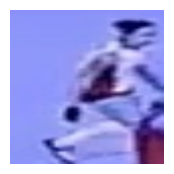

In [13]:
frame , label = data_loader[50]

label_idex = label.argmax().item()
print(f"{people_activity_clases[label_idex]}")

plt.figure(figsize=(2, 2)) 
plt.imshow(frame.permute(1,2,0))  # Converts from (C, H, W) to (H, W, C)
plt.axis('off')  # Optional: to hide axes
plt.show()

In [14]:
transforms = A.Compose([
    A.Resize(224, 224),  
    ToTensorV2()
])

data_loader = Person(videos_path, annot_path, split=train_spilt, seq=True, labels=person_activity_labels, transform=transforms)

In [ ]:
len(data_loader)

In [ ]:
clip, label = data_loader[100]  

label.shape # (12 player , 9 frame , label of 9 class)

In [ ]:
label[0, 0, :]

In [ ]:
clip.shape #  (12 player, 9 frame, C, H, W)

In [ ]:
label_idex = label[0, 0].argmax().item()
print(f"{people_activity_clases[label_idex]}")

plt.figure(figsize=(2, 2)) # frist player  - first frame
plt.imshow(clip[0, 0].permute(1, 2, 0).numpy())  # Converts from (C, H, W) to (H, W, C)
plt.axis('off')  # Optional: to hide axes
plt.show()

In [15]:
transforms = A.Compose([
    A.Resize(224, 224),  
    ToTensorV2()
])


data_loader = Group(videos_path, annot_path, split=train_spilt, crops=False , seq=True, labels=group_activity_labels, transform=transforms)

In [16]:
len(data_loader) 

2152

In [17]:
frame , label = data_loader[0]

In [18]:
print(label.shape) # (,8)
label 

torch.Size([9, 8])


tensor([[0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]])

In [ ]:
index = data_loader[0][1].argmax().item()
print(f"{group_activity_clases[index]}")

plt.imshow(data_loader[0][0].permute(1,2,0)) 
plt.show()

In [ ]:
transforms = A.Compose([
    A.Resize(224, 224),  
    ToTensorV2()
])

data_loader= Group(videos_path, annot_path, split=train_spilt, crops=True , seq=False, labels=group_activity_labels, transform=transforms)

In [ ]:
len(data_loader) # the differents between case 1 and 2 the input consist of 12 bbox

In [ ]:
frame_crops, label = data_loader[152]

In [ ]:
print(label.shape) # (,8)
label

In [ ]:
frame_crops.shape # (12, C, H, W) ---> 12 bbox of the frame

In [3]:
import os 
import sys
import torch
import yaml
import random
import numpy as np
import torch.nn as nn
import albumentations as A
import torch.optim as optim
import torch.multiprocessing as mp
from datetime import datetime
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from models.baseline1.BaseLine1 import Group_Activity_Classifer


from DataLoader import Group, group_activity_labels
from eval_utils import get_f1_score , plot_confusion_matrix
from helper_utils import load_config, setup_logging, save_checkpoint_model


Project_Root = r"H:\Group-Activity-Recognition"
Config_file_path = r"H:\Group-Activity-Recognition\CVR16\configs\Baseline1.yml"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    


def validation(model, val_loader, criterion, device, epoch, writer, logger, class_names):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    y_true = []
    y_pred = []
    with torch.no_grad(): 
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            _, target_class = targets.max(1) 
            total += targets.size(0)
            correct += predicted.eq(target_class).sum().item()
            
            y_true.extend(target_class.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    
    f1_score = get_f1_score(y_true, y_pred, average="weighted")
    writer.add_scalar('Validation/F1Score', f1_score, epoch)
    
    fig = plot_confusion_matrix(y_true, y_pred, class_names)
    writer.add_figure('Validation/ConfusionMatrix', fig, epoch)
    
    writer.add_scalar('Validation/Loss', avg_loss, epoch)
    writer.add_scalar('Validation/Accuracy', accuracy, epoch)
    
    logger.info(f"Epoch {epoch} | Valid Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}% | F1 Score: {f1_score:.4f}")
    
    return avg_loss, accuracy
    
def train_model(Config_file_path):
    config = load_config(Config_file_path)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    exp_dir = os.path.join(
        f"{Project_Root}/training/baseline1/{config["experiment"]['output_dir']}",
        f"{config["experiment"]['name']}_V{config["experiment"]['version']}_{timestamp}"
    )
    os.makedirs(exp_dir, exist_ok=True)
    
    logger = setup_logging(exp_dir)
    logger.info(f"Starting experiment: {config["experiment"]['name']}_V{config["experiment"]['version']}")

    writer = SummaryWriter(log_dir=os.path.join(exp_dir, 'tensorboard'))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")
    
    set_seed(config["experiment"]['seed'])
    logger.info(f"Set random seed: {config["experiment"]['seed']}")
    
    train_transforms = A.Compose([
        A.Resize(224, 224),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 7)),
            A.ColorJitter(brightness=0.2),
            A.RandomBrightnessContrast(),
            A.GaussNoise()
        ], p=0.90),
        A.OneOf([
            A.HorizontalFlip(),
            A.VerticalFlip(),
        ], p=0.05),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])
    
    val_transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])
    
    train_dataset = Group(
        videos_path=f"{config["data"]['videos_path']}",
        annot_path=f"{config["data"]['annot_path']}",
        split=config["data"]['video_splits']['train'],
        labels=group_activity_labels, 
        transform=train_transforms
    )
    
    val_dataset = Group(
        videos_path=f"{config["data"]['videos_path']}",
        annot_path=f"{config["data"]['annot_path']}",
        split=config["data"]['video_splits']['validation'],
        labels=group_activity_labels,
        transform=val_transforms
    )
    
    logger.info(f"Training dataset size: {len(train_dataset)}")
    logger.info(f"Validation dataset size: {len(val_dataset)}")
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config["training"]['batch_size'],
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config["training"]['batch_size'],
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    model = Group_Activity_Classifer(
        num_classes=len(group_activity_labels),
    )
    model =  model.to(device)
    optimizer = optim.AdamW(
        model.parameters(),
        lr= config["training"]['learning_rate'],
        weight_decay=config["training"]['weight_decay']
    )
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler() # for mixed precision training 
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=3,
        verbose=True
    ) # reduce the learning rate when the validation loss plateaus
    config_save_path = os.path.join(exp_dir, 'config.yaml')
    with open(config_save_path, 'w') as config_file:
        yaml.dump(config, config_file)
    logger.info(f"Configuration saved to {config_save_path}")
    
    logger.info("starting training...")
    
    for epoch in range(config["training"]['epochs']):
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        model.train()
        logger.info(f'epoch {epoch+1}/{config["training"]["epochs"]}\n')
        
        for batch_idx ,(images , labels) in enumerate(train_loader):
            images = images.to(device) 
            labels = labels.to(device)
            optimizer.zero_grad()
            with autocast():
                preds = model(images)
                loss = criterion(preds, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            predicted_classes  = preds.argmax(dim=1)
            true_classes = labels.argmax(dim=1)
            total_samples += labels.size(0)
            total_correct += (predicted_classes == true_classes).sum().item()
            
            if batch_idx %100 == 0:
                logger.info(f"Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f} - Accuracy: {total_correct/total_samples:.4f}")
    
    
        avg_loss = total_loss / len(train_loader)
        avg_accuracy =  100. * total_correct / total_samples
        logger.info(f"Epoch {epoch+1}/{config["training"]["epochs"]} - Loss: {avg_loss:.4f} - Accuracy: {avg_accuracy:.2f}%")
        
        writer.add_scalar('loss/train' , avg_loss, epoch)
        writer.add_scalar('accuracy/train' , avg_accuracy, epoch)
        val_loss, val_acc = validation(model, val_loader, criterion, device, epoch, writer, logger, config.model['num_clases_label'])
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar('Training/LearningRate', current_lr, epoch)
        logger.info(f'Current learning rate: {current_lr}')
        save_checkpoint_model(model, optimizer, epoch, val_acc, config, exp_dir)
       
    writer.close()
    final_model_path = os.path.join(exp_dir, 'final_model.pth')
    torch.save({
        'epoch': config.training['epochs'],
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': val_acc,
        'config': config,
    }, final_model_path)
    
    logger.info(f"Training completed. Final model saved to: {final_model_path}")
        

In [4]:
train_model(Config_file_path)

2025-04-26 02:08:33,601 [INFO] Starting experiment: Baseline_B1_V1
2025-04-26 02:08:33,611 [INFO] Using device: cpu
2025-04-26 02:08:33,625 [INFO] Set random seed: 31
2025-04-26 02:08:37,583 [INFO] Training dataset size: 19368
2025-04-26 02:08:37,584 [INFO] Validation dataset size: 12069
2025-04-26 02:08:38,453 [INFO] Configuration saved to H:\Group-Activity-Recognition/training/baseline1/outputs\Baseline_B1_V1_20250426_020833\config.yaml
2025-04-26 02:08:38,455 [INFO] starting training...
2025-04-26 02:08:38,457 [INFO] epoch 1/5



C:\Users\ALkamaL\AppData\Local\Temp\ipykernel_11884\1087055522.py:168: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # for mixed precision training
c:\Users\ALkamaL\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
c:\Users\ALkamaL\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 

In [2]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join('..'))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

In [ ]:
import sys 
import os
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
from datetime import datetime
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from albumentations.pytorch import ToTensorV2
import albumentations as A
from models.LstmGroup import LSTMGroup
from dataloader.DataLoader import Group, group_activity_labels
from eval_utils import get_f1_score, plot_confusion_matrix
from helper_utils import load_config, setup_logging, save_checkpoint_model
from baselines.trainer import Tranier


Project_Root = r"H:\Group-Activity-Recognition"
Config_file_path = r"H:\Group-Activity-Recognition\CVR16\configs\Baseline4.yml"

sys.path.append(os.path.abspath(PROJECT_ROOT))

from dataloader.DataLoader import Group, group_activity_labels
from eval_utils import get_f1_score , plot_confusion_matrix
from helper_utils import load_config, setup_logging, save_checkpoint_model



class LSTM_Trainer():
    def __init__(self , config_file_path, project_root):
        self.Project_Root = project_root
        self.config =  load_config(config_file_path)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.exp_dir = os.path.join(
            f"{self.Project_Root}/training/baseline4/{self.config['experiment']['output_dir']}",
            f"{self.config['experiment']['name']}_V{self.config['experiment']['version']}_{timestamp}"
        )
        self.device = torch.device("cuuda" if torch.cuda.is_available() else "cpu")
        os.makedirs(self.exp_dir, exist_ok=True)
        self.model  = LSTMGroup(
            input_size=self.config['model']['input_size'],
            hidden_size=self.config['model']['hidden_size'],
            num_layers=self.config['model']['num_layers'],
            num_classes=self.config['model']['num_classes'],
        ).to(self.device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(),
                        lr= self.config['training']['learning_rate'],
                        weight_decay=self.config['training']['weight_decay'])
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=3, verbose=True )
        self.scaler = GradScaler('cuda')
        class_weights = self.calculate_class_weights(self.train_loader)
        self.criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        self.logger = setup_logging(self.exp_dir)
        self.writer = SummaryWriter(log_dir=os.path.join(self.exp_dir, 'tensorboard'))
        self.train_loader, self.val_loader = self.prepare_data()
        self.class_names = self.config['model']['num_classes_label']
        config_save_path = os.path.join(self.exp_dir, 'config.yaml')
        with open(config_save_path, 'w') as config_file:
            yaml.dump(self.config, config_file)
        self.logger.info(f"Configuration saved to {config_save_path}")
    
    def concat(self , batch):
        clips , label = zip(*batch)
        clips , label  = torch.stack(clips , dim =0) , torch.stack(label , dim =0)
        labels = labels[:, -1, :]  
        return clips, labels
        
    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    def prepare_data(self):
        train_transforms = A.Compose([
            A.Resize(224, 224),
            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 7)),
                A.ColorJitter(brightness=0.2),
                A.RandomBrightnessContrast(),
                A.GaussNoise()
            ], p=0.80),
            A.OneOf([A.HorizontalFlip(), A.VerticalFlip()], p=0.05),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

        val_transforms = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
        train_dataset = Group(
            videos_path=self.config['data']['videos_path'],
            annot_path=self.config['data']['annot_path'],
            split=self.config['data']['video_splits']['train'],
            labels=group_activity_labels,
            transform=train_transforms
        )

        val_dataset = Group(
            videos_path=self.config['data']['videos_path'],
            annot_path=self.config['data']['annot_path'],
            split=self.config['data']['video_splits']['validation'],
            labels=group_activity_labels,
            transform=val_transforms
        )
        
        self.logger.info(f"Training dataset size: {len(train_dataset)}")
        self.logger.info(f"Validation dataset size: {len(val_dataset)}")
        
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config['training']['batch_size'],
            shuffle=True, num_workers=4, pin_memory=True
            )
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config['training']['batch_size'],
            shuffle=False, num_workers=4, pin_memory=True
            )
        return train_loader, val_loader
    
    def calculate_class_weights(self , train_loader):
        labels = [label.argmax().item() for batch in train_loader for label in batch[1]]
        class_counts = torch.bincount(torch.tensor(labels))
        total_samples = len(labels)
        class_weights = total_samples / (len(class_counts) * class_counts)
        class_weights = class_weights / class_weights.sum()
        return class_weights.to(self.device)
    
        
    def validate(self , epoch):
        self.model.eval()
        total_loss, correct, total = 0, 0, 0
        y_true, y_pred = [], []
        
        with torch.no_grad():
            for inputs , targets in self.val_loader:
                inputs , targets  =  inputs.to(self.device) , targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
                _, predicted = outputs.argmax(1)
                _, target_class = targets.argmax(1)
                total += targets.size(0)
                correct += predicted.eq(target_class).sum().item()

                y_true.extend(target_class.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        
        avg_loss = total_loss / len(self.val_loader)
        accuracy = 100. * correct / total
        f1_score = get_f1_score(y_true, y_pred, average="weighted")
        self.writer.add_scalar('Validation/Loss', avg_loss, epoch)
        self.writer.add_scalar('Validation/Accuracy', accuracy, epoch)
        self.writer.add_scalar('Validation/F1Score', f1_score, epoch)
        self.writer.add_figure('Validation/ConfusionMatrix', plot_confusion_matrix( y_true, y_pred, class_names = self.config["model"]['num_classes_label'] , save_path = "/kaggle/working/"))

        self.logger.info(f"Epoch {epoch} | Valid Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}% | F1 Score: {f1_score:.4f}")
        return avg_loss, accuracy
        
    def train(self):
        self.logger.info("Starting training...")
        
        for epoch in range(self.config['training']['epochs']):
            self.model.train()
            total_loss, total_correct, total_samples = 0, 0, 0  
            self.logger.info(f"Epoch {epoch + 1}/{self.config['training']['epochs']}")

            for batch_idx, (images, labels) in enumerate(self.train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()

                with autocast(dtype=torch.float16):
                    preds = self.model(images)
                    loss = self.criterion(preds, labels)

                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()

                total_loss += loss.item()
                predicted_classes = preds.argmax(dim=1)
                true_classes = labels.argmax(dim=1)
                total_samples += labels.size(0)
                total_correct += (predicted_classes == true_classes).sum().item()
                if batch_idx % 100 == 0:
                    acc = total_correct / total_samples
                    self.logger.info(f"Batch {batch_idx}/{len(self.train_loader)} - Loss: {loss.item():.4f} - Accuracy: {acc:.4f}")

            avg_loss = total_loss / len(self.train_loader)
            avg_accuracy = 100. * total_correct / total_samples
            self.writer.add_scalar('loss/train', avg_loss, epoch)
            self.writer.add_scalar('accuracy/train', avg_accuracy, epoch)

            self.logger.info(f"Epoch {epoch + 1} Summary: Loss: {avg_loss:.4f} | Accuracy: {avg_accuracy:.2f}%")

            val_loss, val_acc = self.validate(epoch)
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            self.writer.add_scalar('Training/LearningRate', current_lr, epoch)
            self.logger.info(f"Current learning rate: {current_lr}")

            save_checkpoint_model(self.model, self.optimizer, epoch, val_acc,  self.exp_dir , self.config)

        self.writer.close()
        self.save_model()

    def save_model(self):
        final_model_path = os.path.join(self.exp_dir, 'final_model.pth')
        torch.save({
            'epoch': self.config['training']['epochs'],
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'config': self.config,
        }, final_model_path)
        self.logger.info(f"Training completed. Final model saved to: {final_model_path}")
           

c:\Users\ALkamaL\anaconda3\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


ModuleNotFoundError: No module named 'models'